### Class Accuracies for Imbalanced Data in Deep Learning Image Recognition
- Class Imbalance is major issue when we train a neural network, which happens because of different class have diffrent frequency distribution.

### Dataset : [Catlech256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/)
- Total Images: **30698**
- Total Classes : **257**
- Actually how imbalanced is the Caltech256 vision dataset? The following bar plot will give a better idea of the image number distributions.
![](https://debuggercafe.com/wp-content/uploads/2020/03/distribution.gif)
- [Source](http://www.vision.caltech.edu/Image_Datasets/Caltech256/intro/)
- Most of the categories have images between 80 to 150 and Some Category contains more than 200 to 300 images and clutter class substracted because of the highest 827 images contained.
![](https://debuggercafe.com/wp-content/uploads/2020/03/class_dist.png)

### **1.Load Libraries**

In [1]:
import os
try:
    from imutils import paths
    import pretrainedmodels
except:
    os.system("pip install imutils pretrainedmodels")
    
import matplotlib.pyplot as plt
import joblib
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
plt.style.use('ggplot')

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pretrainedmodels
import random

'''
seed Everything
'''
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True # as we will resize the images
    
seed = 42
seed_everything(seed)

In the above code block, some of the important modules are:

* `torch.nn` will help us access the neural network layers in the PyTorch library.
* `torch.optim` to access all the optimizer functions in PyTorch.
* `pretrainedmodels` to access all the pre-trained models like `ResNet34` and many more. We installed this library in one of the previous sections.
* Using `torchvision.transforms` we can apply `transforms` to our image like `normalization` and `resizing`.
* `DataLoader` and `Dataset` from the `torchvision.transforms` will help us to create our own custom image dataset module and iterable data loaders.
* `cv2` to read images in the dataset.

### **2.Load the Devices**

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 10

### **3.Define the Transforms**

In [3]:
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                             std = [0.229, 0.224, 0.225])
    ]
)
val_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],std=[0.229, 0.224, 0.225])
    ]
)

### **4.Images and Labels**

In [4]:
image_paths = list(paths.list_images('./101_ObjectCategories'))

data = []
labels = []
for image_path in tqdm(image_paths, total=len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    if label == 'clutter':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    
    data.append(image)
    labels.append(label)
    
data = np.array(data)
labels  = np.array(labels)    

100%|██████████| 9144/9144 [00:10<00:00, 872.85it/s] 


### **5.Label Encoder**

In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 102


### **6.Preparing train, test and Validation Dataset**

In [6]:
(X, X_val, y, y_val) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=seed)
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.25, random_state=seed)
print(f"X_Train: {X_train.shape} X_Val: {X_val.shape} X_Test: {X_test.shape}")
print(f"Y_Train: {y_train.shape} y_Val: {y_val.shape} y_Test: {y_test.shape}")

X_Train: (5486, 128, 128, 3) X_Val: (1829, 128, 128, 3) X_Test: (1829, 128, 128, 3)
Y_Train: (5486, 102) y_Val: (1829, 102) y_Test: (1829, 102)


### **7.Prepare the Image Dataset using Train Loader and Test Loader**

In [7]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.X = images
        self.y = labels
        self.transforms = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        data = self.X[index]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            label = self.y[index]
            return data, label
        else:
            return data
        
train_Data = ImageDataset(X_train, y_train, transform=train_transform)
val_Data = ImageDataset(X_val, y_val, transform=val_transform)
test_Data = ImageDataset(X_test, y_test, transform=val_transform)

# Data Loader (Input Pipeline)
trainloader = DataLoader(dataset=train_Data, batch_size=32, shuffle=True)
valloader = DataLoader(dataset=val_Data, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=test_Data, batch_size=32, shuffle=True)    

### **8.Design Neural Network**

In [8]:
class ResNet50(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        self.l0 = nn.Linear(2048, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        batch, channels, height, width = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0
        

In [15]:
model = ResNet50(pretrained=True).to(device)
print(model)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss function
criterion = nn.CrossEntropyLoss()

ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

### **9.Print Model Summary**

In [10]:
from torchsummary import summary
print(summary(model, input_size=(3, 224, 224)))

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              75,008
|    |    └─Bottleneck: 3-2              70,400
|    |    └─Bottleneck: 3-3              70,400
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              379,392
|    |    └─Bottleneck: 3-5              280,064
|    |    └─Bottleneck: 3-6              280,064
|    |    └─Bottleneck: 3-7              280,064
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              1,512,448
|    |    └─Bottleneck: 3-9              1,117,184
|    |    └─Bottleneck: 3-10             1,117,184
|    |    └─Bottleneck: 3-11             1,117,184
|    |    └─Bottleneck: 3-12             1,117,184


### **10.Train Validation and Test Function**

In [16]:
# training function
def fit(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_Data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [17]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_Data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

* In the functions, `validate()`, and `fit()`, we calculate the batch-wise loss and accuracy values. We call those variables `running_loss`, and `running_correct`.
* At the end of both the functions, we return the `loss` and `accuracy` for that specific epoch.

In [18]:
def class_acc_test(model, testloader):
    class_correct = list(0. for i in range(len(lb.classes_)))
    class_total = list(0. for i in range(len(lb.classes_)))
    with torch.no_grad():
        for data in testloader:
            inputs, target = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == torch.max(target, 1)[1])
            for i in range(len(predicted)):
                label = torch.max(target, 1)[1][i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
                
    for i in range(len(lb.classes_)):
        print(f"Accuracy of {lb.classes_[i]} : {100 * class_correct[i] / class_total[i]:.2f}")    

### **11.Executing Training and validation Function**

In [20]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}");print('-'*20)
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Epoch 1 of 10
--------------------
Training


172it [00:52,  3.30it/s]                         


Train Loss: 0.0009, Train Acc: 99.58
Validating


58it [00:07,  7.52it/s]                        


Val Loss: 0.0062, Val Acc: 95.24
Epoch 2 of 10
--------------------
Training


172it [00:55,  3.10it/s]                         


Train Loss: 0.0007, Train Acc: 99.69
Validating


58it [00:08,  7.21it/s]                        


Val Loss: 0.0070, Val Acc: 94.31
Epoch 3 of 10
--------------------
Training


172it [00:49,  3.51it/s]                         


Train Loss: 0.0008, Train Acc: 99.60
Validating


58it [00:07,  7.78it/s]                        


Val Loss: 0.0079, Val Acc: 93.88
Epoch 4 of 10
--------------------
Training


172it [00:49,  3.46it/s]                         


Train Loss: 0.0021, Train Acc: 98.52
Validating


58it [00:07,  7.46it/s]                        


Val Loss: 0.0148, Val Acc: 89.12
Epoch 5 of 10
--------------------
Training


172it [00:51,  3.35it/s]                         


Train Loss: 0.0028, Train Acc: 98.27
Validating


58it [00:08,  6.71it/s]                        


Val Loss: 0.0124, Val Acc: 89.39
Epoch 6 of 10
--------------------
Training


172it [00:52,  3.29it/s]                         


Train Loss: 0.0015, Train Acc: 99.14
Validating


58it [00:07,  7.29it/s]                        


Val Loss: 0.0092, Val Acc: 92.40
Epoch 7 of 10
--------------------
Training


172it [00:51,  3.35it/s]                         


Train Loss: 0.0010, Train Acc: 99.40
Validating


58it [00:07,  7.33it/s]                        


Val Loss: 0.0102, Val Acc: 91.91
Epoch 8 of 10
--------------------
Training


172it [00:51,  3.37it/s]                         


Train Loss: 0.0012, Train Acc: 99.31
Validating


58it [00:07,  7.46it/s]                        


Val Loss: 0.0139, Val Acc: 90.21
Epoch 9 of 10
--------------------
Training


172it [00:51,  3.33it/s]                         


Train Loss: 0.0013, Train Acc: 99.03
Validating


58it [00:07,  8.03it/s]                        


Val Loss: 0.0113, Val Acc: 90.54
Epoch 10 of 10
--------------------
Training


172it [00:50,  3.40it/s]                         


Train Loss: 0.0014, Train Acc: 99.14
Validating


58it [00:06,  8.49it/s]                        

Val Loss: 0.0093, Val Acc: 92.45
9.870497596263885 minutes


### **12.Save Model**

In [22]:
os.makedirs("model", exist_ok=True)
torch.save(model.state_dict(), f"model/resnet50_epochs{epochs}.pth")

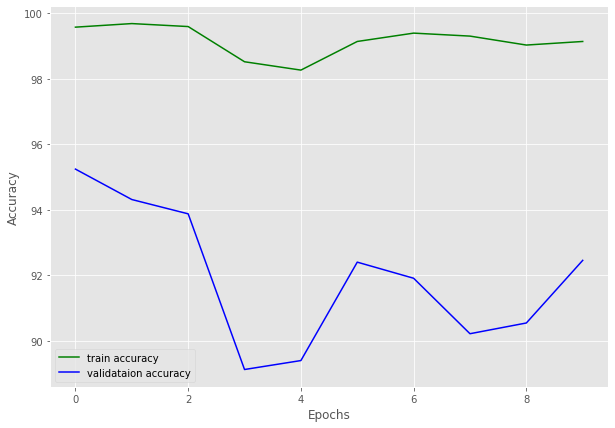

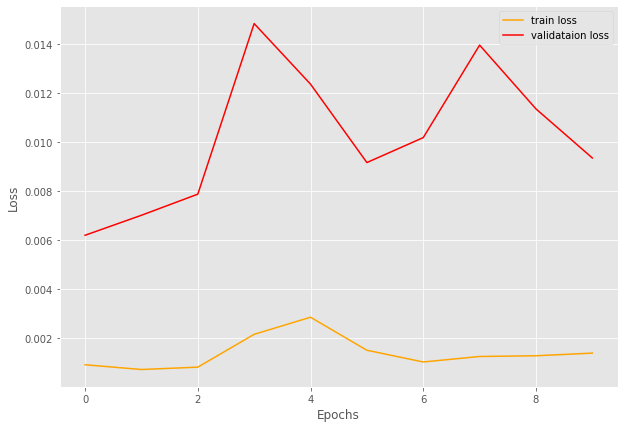

In [23]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('../outputs/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/loss.png')
plt.show()
# pickling the accuracy and loss values
# joblib.dump(train_accuracy, '../outputs/train_accuracy.pkl')
# joblib.dump(train_loss, '../outputs/train_loss.pkl')
# joblib.dump(val_accuracy, '../outputs/val_accuracy.pkl')
# joblib.dump(val_loss, '../outputs/val_loss.pkl')

### **13.Class wise Accuracy**

In [24]:
# test the model for per-class accuracy
class_acc_test(model, testloader)

Accuracy of BACKGROUND_Google : 70.21
Accuracy of Faces : 100.00
Accuracy of Faces_easy : 98.88
Accuracy of Leopards : 100.00
Accuracy of Motorbikes : 100.00
Accuracy of accordion : 100.00
Accuracy of airplanes : 99.34
Accuracy of anchor : 83.33
Accuracy of ant : 77.78
Accuracy of barrel : 100.00
Accuracy of bass : 75.00
Accuracy of beaver : 100.00
Accuracy of binocular : 100.00
Accuracy of bonsai : 100.00
Accuracy of brain : 100.00
Accuracy of brontosaurus : 77.78
Accuracy of buddha : 100.00
Accuracy of butterfly : 90.00
Accuracy of camera : 81.82
Accuracy of cannon : 75.00
Accuracy of car_side : 100.00
Accuracy of ceiling_fan : 50.00
Accuracy of cellphone : 100.00
Accuracy of chair : 80.00
Accuracy of chandelier : 73.08
Accuracy of cougar_body : 100.00
Accuracy of cougar_face : 100.00
Accuracy of crab : 61.54
Accuracy of crayfish : 62.50
Accuracy of crocodile : 78.57
Accuracy of crocodile_head : 77.78
Accuracy of cup : 100.00
Accuracy of dalmatian : 100.00
Accuracy of dollar_bill : 1